## Import Library and Funcitons

In [1]:
import datetime
import logging
import numpy as np
import pandas as pd
import sklearn.metrics
import xgboost
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from ds_utils import e4
from ds_utils import aggregators
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import ds_utils
import ds_utils.e4
from ds_utils.training import support

In [2]:
def training_to_xgb(dfs) -> xgboost.XGBClassifier:
    """Pass a list of dataframes to be used as training data for an XGBoost classifier
    Args:
        dfs (list[pd.DataFrame]): a list of aggregated data dataframes
    Returns:
        xgboost.XGBClassifier: a trained classifier
    
    """
    data = pd.concat(dfs, axis=0)
    X = data.drop(columns=['craving_onset']).values
    Y = data['craving_onset'].map({True: 1, False: 0}).values

    model = xgboost.XGBClassifier(max_depth=9, subsample=0.9, colsample_bytree=0.3, objective='binary:logistic', n_estimators=400, learning_rate=0.15)
    model.fit(X, Y)

    return model

def test_xgb(df: pd.DataFrame, model: xgboost.XGBClassifier) -> np.ndarray:
    """Make predictions from a trained xgboost model on aggregated data
    Args:
        df (pd.DataFrame): test dataframe
        model (xgboost.XGBClassifier): trained model
    Returns:
        np.ndarray: the predicted values
    
    """
    X = df.drop(columns=['craving_onset']).values
    Y = df['craving_onset'].map({True: 1, False: 0}).values

    Y_pred = model.predict(X)
    predictions = [round(value) for value in Y_pred]
    accuracy = sklearn.metrics.accuracy_score(Y, Y_pred)
    precision = precision_score(Y, Y_pred, average='macro')
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Precision: %.2f%%" % (precision * 100.0))
    print(sklearn.metrics.confusion_matrix(Y, Y_pred))
    return Y_pred

def prepare_data_resample(pir, part):
    """Prepare data for predictions on the interested emotion.The returned dataframe will include all six emotions
        The function use aggregate function in ds_util
    Args:
        pir (int): person in recovery id number
        part (int): part of the file to load
        time_windows (Iterable[str]): a list of a window sizes in units that can be used for resample
    Returns: 
        pd.DataFrame: data with all six emotions ready for the xgboost model (and function XGBRegressorForSurveyFast)
    """
    emotion_list = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad']
    data = e4.read(pir, part=part, base_path='./data').add_craving_onset(2, 0, column_name='craving_onset')
    data = data.df.resample('1 s').mean()
    data = support.clean_nan_reference_column(data, 'bvp')
    status = pd.read_parquet(f'./data/pir{pir}_status.pq', engine='auto')

    for emotion in emotion_list:
        status = status[status[emotion].first_valid_index():status[emotion].last_valid_index()]
        
    means = data.resample('40 min').mean().add_suffix('_mean')
    stds = data.resample('40 min').std().add_suffix('_std')
    firsts = data.resample('40 min').last().add_suffix('_raw')
    out = firsts.join(means)
    data = out.join(stds)
    data = data.dropna()

    df = data.join(status, how='outer').sort_index()
    drop_list=['hash', 'is_craving', 'report_offset_hrs','id', 'duration_participation_s','craving_freq', 
               'need_help', 'support', 'report', 'cravings_today', 'craving_onset_mean', 'craving_onset_std']
    df= df.drop(drop_list,axis=1)

    for emotion in emotion_list:
        df = df[df[emotion].first_valid_index():df[emotion].last_valid_index()]

    for emotion in emotion_list:
        df[emotion] = df[emotion].ffill()

    df=df.dropna()
    
    return df

def XGBRegressorForSurveyFast (df, test, emotion, learning_rate = 0.15, max_depth = 9, colsample_bytree = 0.3,
                           subsample = 0.9):
    """predict the pir's emotions on a scale from 1 to 10  
    
    Args: 
        df (pd.DataFrame): the data set we need for the training and test data
        emotion (str): the emotion we are going to predict
        learning_rate (float): learning rate of XGB model, range [0, 1]. Defaults to 0.1
        max_depth (int): maximum depth of tree. Defaults to 5
        colsample_bytree (float): fraction of columns to be randomly sampled for each tree. Defaults to 0.3
        subsample (float): fraction of observations to be randomly sampled for each tree. Defaults to 0.8
    Return:
        xgboost.XGBRegressor: a trained regressor to predict on emotions
    """  
    
    # delete uneccessary columns
    emotionList = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad'] 
    emotionList.remove(emotion)
    dropList = emotionList + ['craving_onset_raw']
    df = df.drop(dropList, axis=1)
    test = test.drop(dropList, axis=1)

     # get the name of columns for features
    new_cols = [col for col in df.columns if col != emotion] + [emotion]
    df = df[new_cols]
    test = test[new_cols]
    feature_columns = new_cols[:-1]

    # Isolate the x and y variables
    y = df.iloc[:, -1].values
    X = df.iloc[:, :-1].values
    
    test_y = test.iloc[:, -1].values
    test_X = test.iloc[:, :-1].values   
    
    finalModel = xgb.XGBRegressor(objective="reg:squarederror", learning_rate = learning_rate, max_depth = max_depth,
                                  colsample_bytree = colsample_bytree, subsample = subsample, n_estimators=100,random_state=123)
    finalModel.fit(X, y)
    
    # Predictions on test dataset
    preds = finalModel.predict(test_X)
    
    # plot pred and pred-actual
    fig, ax = plt.subplots(3, 1, figsize=(12,12))
    ax[0].hist(preds, bins = 50)
    ax[1].hist(test_y, bins = 50)
    ax[2].hist(preds - test_y, bins = 50)
    ax[0].set_title('pred')
    ax[1].set_title('actual')
    ax[2].set_title('pred - actual')

    plt.show()
    
    # show results
    rmse = np.sqrt(mean_squared_error(test_y, preds))
    print("RMSE: %f" % (rmse))
    
    
    # plot feature importances
    xgb.plot_importance(finalModel, max_num_features = 10)
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.show()
    
    # plot true val vs. predictions
    true_val = test[emotion].values
    plt.plot(true_val)
    plt.plot(preds)
    plt.title("true val vs. predictions")
    plt.show()
    return finalModel

def df_with_emotion(df, model, emotion):
    """produce a new dataframe with predicted emotion attached to it
    
    Args: 
        df (pd.DataFrame): can be the same data used for the emotion prediction
        model (xgboost.XGBRegressor): used to produce prediction on the emotion
        emotion (str) : the emotion we are interested in
    Return:
        pd.DataFrame: a dataframe with the interested emotion attached
    """
    emotionList = ['relaxed', 'happy', 'stressed', 'tired', 'anxious','sad']
    dropList = emotionList + ['craving_onset_raw']
    df_X = df.drop(dropList, axis=1, errors='ignore')
    df[f"pred_{emotion}"] = model.predict(df_X.values)
    df = df.drop(emotionList, axis=1, errors='ignore')
    return df

def classify(train, test):
    X = train.drop(columns=['craving_onset_raw']).values
    Y = train['craving_onset_raw'].values
    negs = np.arange(len(Y))[Y == 0]
    use_Y = (Y > 0)
    use_Y[np.random.choice(negs, int(1.5*sum(Y)), replace=False)] = True
    X = X[use_Y, :]
    Y = Y[use_Y]
    model = xgboost.XGBClassifier(max_depth=9, subsample=0.9, colsample_bytree=0.3, objective='binary:logistic', n_estimators=100, learning_rate=0.15)
    model.fit(X, Y, eval_metric=["error", "logloss"], verbose=True)
    X_test = test.drop(columns=['craving_onset_raw']).values
    Y_test = test['craving_onset_raw'].values
    y_pred = model.predict(X_test)
    best_preds = [round(value) for value in y_pred]
    precision = sklearn.metrics.precision_score(Y_test, best_preds, average='macro')
    accuracy = sklearn.metrics.accuracy_score(Y_test, best_preds)
    print(precision, accuracy)
    print(sklearn.metrics.confusion_matrix(Y_test, best_preds))
    return model


## Prepare data

In [3]:
df1 = prepare_data_resample(89, 1)
df1.head()

,acc_x_raw,acc_y_raw,acc_z_raw,bvp_raw,conductance_raw,heartrate_raw,temperature_raw,craving_onset_raw,acc_x_mean,acc_y_mean,...,bvp_std,conductance_std,heartrate_std,temperature_std,relaxed,happy,stressed,tired,anxious,sad
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 18:00:00,-56.21875,9.50000,26.96875,132.850104,0.000960,81.04,34.41,0.0,24.451959,-0.229944,...,41.785902,0.006686,3.507279,5.458700,6.0,8.0,7.0,7.0,8.0,8.0
2020-01-28 18:40:00,57.25000,7.78125,22.96875,10.946146,0.098923,92.80,33.57,0.0,47.237266,-5.348984,...,53.854704,0.046174,12.413319,0.275912,6.0,8.0,7.0,7.0,8.0,8.0
2020-01-28 19:20:00,50.21875,23.81250,-32.56250,-35.947656,0.298817,82.13,34.50,0.0,39.476386,-17.966764,...,59.896358,0.073939,12.124562,1.194874,6.0,8.0,7.0,7.0,8.0,8.0
2020-01-28 20:00:00,56.87500,16.09375,-21.40625,82.140260,0.120125,75.15,34.93,0.0,43.534505,19.754336,...,61.167156,0.838729,12.019493,0.201121,6.0,8.0,7.0,7.0,8.0,8.0
2020-01-28 20:40:00,47.75000,8.65625,-35.46875,-71.628281,4.208338,75.02,34.18,0.0,40.309271,18.982279,...,64.074571,1.349273,11.576211,0.678074,6.0,8.0,7.0,7.0,8.0,8.0


In [4]:
df2 = prepare_data_resample(89, 2)
df3 = prepare_data_resample(89, 3)
test = prepare_data_resample(89, 4)

## Prediction on emotions

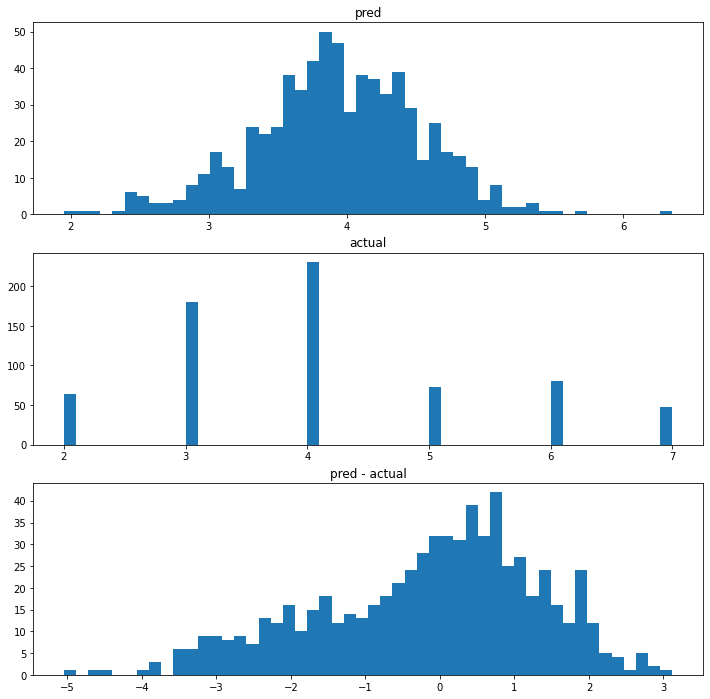

RMSE: 1.501211


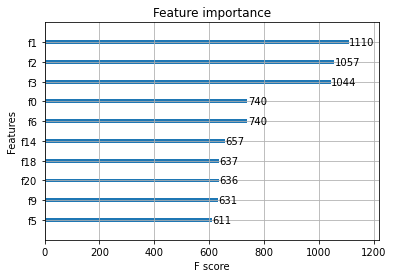

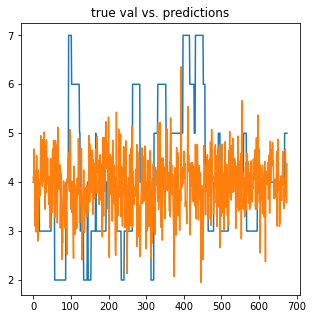

In [5]:
train = pd.concat([df1, df2, df3])
model_emotion = XGBRegressorForSurveyFast(train, test, "stressed")

In [6]:
## add train and test with predicted emotions
train_new = df_with_emotion(train, model_emotion, "stressed")
test_new = df_with_emotion(test, model_emotion, "stressed")
train_new.head()

,acc_x_raw,acc_y_raw,acc_z_raw,bvp_raw,conductance_raw,heartrate_raw,temperature_raw,craving_onset_raw,acc_x_mean,acc_y_mean,...,heartrate_mean,temperature_mean,acc_x_std,acc_y_std,acc_z_std,bvp_std,conductance_std,heartrate_std,temperature_std,pred_stressed
ts,,,,,,,,,,,,,,,,,,,,,
2020-01-28 18:00:00,-56.21875,9.50000,26.96875,132.850104,0.000960,81.04,34.41,0.0,24.451959,-0.229944,...,74.019825,30.877761,34.432769,23.487268,35.218372,41.785902,0.006686,3.507279,5.458700,6.986030
2020-01-28 18:40:00,57.25000,7.78125,22.96875,10.946146,0.098923,92.80,33.57,0.0,47.237266,-5.348984,...,83.261458,33.972550,14.468110,22.455644,23.819942,53.854704,0.046174,12.413319,0.275912,6.867905
2020-01-28 19:20:00,50.21875,23.81250,-32.56250,-35.947656,0.298817,82.13,34.50,0.0,39.476386,-17.966764,...,82.562912,33.201364,21.181245,27.222569,27.952650,59.896358,0.073939,12.124562,1.194874,6.846747
2020-01-28 20:00:00,56.87500,16.09375,-21.40625,82.140260,0.120125,75.15,34.93,0.0,43.534505,19.754336,...,89.208146,34.688054,17.716355,23.393130,25.566492,61.167156,0.838729,12.019493,0.201121,6.911818
2020-01-28 20:40:00,47.75000,8.65625,-35.46875,-71.628281,4.208338,75.02,34.18,0.0,40.309271,18.982279,...,85.608154,33.980492,19.600081,25.149353,23.235541,64.074571,1.349273,11.576211,0.678074,6.893787


## prediction on craving_onset

In [7]:
model = classify(train_new, test_new)

0.5000646997929606 0.7066666666666667
[[473 188]
 [ 10   4]]


/Users/yangtian/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [8]:
## Print feature importance
importance = model.feature_importances_
names = train_new.columns
found_index = np.in1d(names, 'craving_onset_raw').nonzero()[0]
names = np.delete(names, found_index)
dataset = pd.DataFrame({'importance': importance, 'names': list(names)}, columns=['importance', 'names'])
dataset.sort_values(by=['importance'], inplace=True, ascending=False)
dataset.head(10)

,importance,names
21,0.077477,pred_stressed
18,0.075533,conductance_std
14,0.074676,acc_x_std
0,0.058547,acc_x_raw
6,0.058146,temperature_raw
12,0.053892,heartrate_mean
3,0.053704,bvp_raw
7,0.050734,acc_x_mean
5,0.048428,heartrate_raw
19,0.046763,heartrate_std


## try to use the first 80% as trainning and last 20% as testing

In [9]:
total_df = pd.concat([train_new, test_new])
train_point = int(round(0.80*len(total_df)))
train_total = total_df.iloc[:train_point]
test_total = total_df.iloc[train_point:]

In [10]:
model = classify(train_total, test_total)

/Users/yangtian/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.49500747778657517 0.776937618147448
[[409 106]
 [ 12   2]]


In [11]:
## Print feature importance
importance = model.feature_importances_
names = train_new.columns
found_index = np.in1d(names, 'craving_onset_raw').nonzero()[0]
names = np.delete(names, found_index)
dataset = pd.DataFrame({'importance': importance, 'names': list(names)}, columns=['importance', 'names'])
dataset.sort_values(by=['importance'], inplace=True, ascending=False)
dataset.head(10)

,importance,names
18,0.080476,conductance_std
21,0.069955,pred_stressed
3,0.056682,bvp_raw
14,0.055491,acc_x_std
5,0.055140,heartrate_raw
12,0.054255,heartrate_mean
7,0.052770,acc_x_mean
0,0.052754,acc_x_raw
15,0.044264,acc_y_std
19,0.044050,heartrate_std
